In [18]:
import sys
sys.path.insert(1,'../../../SUSAN') # Path to SUSAN

In [19]:
# SUSAN requires NUMPY and NUMBA
import susan
import numpy as np
import matplotlib.pyplot as plt

# For visualization
import napari

# To create masks:
from scipy.ndimage import gaussian_filter as gauss
from scipy.ndimage import binary_dilation as dilat

In [3]:
# %% Create Tomostxt:
N = 4
K = 61

tomos = susan.data.Tomograms(n_tomo=N,n_proj=K)
apix  = 2.62
tsiz  = (3710,3710,880)
for i in range(4):
    base = 'data/mixedCTEM_tomo%d' % (i+1)
    tomos.tomo_id[i] = i+1
    tomos.set_stack  (i,base+'.b1.ali.mrc')
    tomos.set_angles (i,base+'.tlt')
    tomos.set_defocus(i,base+'.defocus')
    tomos.pix_size[i]  = apix
    tomos.tomo_size[i] = tsiz
tomos.save('tomos_b1.tomostxt')

tomos = susan.data.Tomograms(n_tomo=N,n_proj=K)
apix  = 2.62*2
tsiz  = (3710/2,3710/2,880/2)
for i in range(4):
    base = 'data/mixedCTEM_tomo%d' % (i+1)
    tomos.tomo_id[i] = i+1
    tomos.set_stack  (i,base+'.b2.ali.mrc')
    tomos.set_angles (i,base+'.tlt')
    tomos.set_defocus(i,base+'.defocus')
    tomos.pix_size[i]  = apix
    tomos.tomo_size[i] = tsiz
tomos.save('tomos_b2.tomostxt')

tomos = susan.data.Tomograms(n_tomo=N,n_proj=K)
apix  = 2.62*4
tsiz  = (3710/4,3710/4,880/4)
for i in range(4):
    base = 'data/mixedCTEM_tomo%d' % (i+1)
    tomos.tomo_id[i] = i+1
    tomos.set_stack  (i,base+'.b4.ali.mrc')
    tomos.set_angles (i,base+'.tlt')
    tomos.set_defocus(i,base+'.defocus')
    tomos.pix_size[i]  = apix
    tomos.tomo_size[i] = tsiz
tomos.save('tomos_b4.tomostxt')

tomos = susan.data.Tomograms(n_tomo=N,n_proj=K)
apix  = 2.62*8
tsiz  = (3710/8,3710/8,880/8)
for i in range(4):
    base = 'data/mixedCTEM_tomo%d' % (i+1)
    tomos.tomo_id[i] = i+1
    tomos.set_stack  (i,base+'.b8.ali.mrc')
    tomos.set_angles (i,base+'.tlt')
    tomos.set_defocus(i,base+'.defocus')
    tomos.pix_size[i]  = apix
    tomos.tomo_size[i] = tsiz
tomos.save('tomos_b8.tomostxt')

In [9]:
# Load DYNAMO table with NUMPY and convert it to PTCLSRAW
tbl_B8 = np.loadtxt('picked_b8.tbl',unpack=True)
tomoB8 = susan.read('tomos_b8.tomostxt')
ptcls  = susan.data.Particles.import_data(tomograms=tomoB8,
                                          position=tbl_B8[23:26,:].transpose(),
                                          ptcls_id=tbl_B8[0],
                                          tomos_id=tbl_B8[19])
ptcls.save('prj_001.ptclsraw')

    Volume reconstruction. Box size: 32
    - Input files: prj_001.ptclsraw | tomos_b8.tomostxt
    - Output prefix: prj_001
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 15.0]  (roll off: 2.00).
    - Wiener Inversion. Normalized to Mean=0, Std=1.
    - c1 Symmetry. Inversion: Ite=10 Std=0.750000
	Loading data files... Done
    - 4427 Particles (1 classes) in 4 tomograms with max 61 projections.
        Filling fourier space: 100.00%                           
        Reconstructing prj_001_class001.mrc ...  Done.


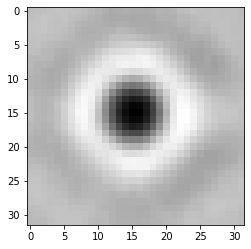

In [16]:
avgr = susan.modules.Averager()
avgr.list_gpus_ids  = [0]
avgr.ctf_correction = 'wiener'
avgr.rec_halfsets   = False
avgr.reconstruct('prj_001','tomos_b8.tomostxt','prj_001.ptclsraw',32)
# Initial reconstruction should looks like a sphere (no angles)
v,_ = susan.io.mrc.read('prj_001_class001.mrc')
plt.imshow(v[16],'gray')

In [3]:
# Duplicate reference to run a MRA project
ptcls = susan.data.Particles('prj_001.ptclsraw')
susan.data.Particles.MRA.duplicate(ptcls,0)
ptcls.save('prj_001_mra.ptclsraw')

In [4]:
susan.io.mrc.write(susan.utils.create_sphere( 4,64),   'gb_b4.mrc'   ,2.62*4)
susan.io.mrc.write(susan.utils.create_sphere(24,64),'mask_sph_b4.mrc',2.62*4)
refs = susan.data.Reference(n_refs=2)
refs.ref[0] = 'emd_3420_b4.mrc'
refs.msk[0] = 'mask_sph_b4.mrc'
refs.ref[1] = 'gb_b4.mrc'
refs.msk[1] = 'mask_sph_b4.mrc'
refs.save('prj_001_b4.refstxt')

In [12]:
mngr = susan.project.Manager('prj_001_b4',64)

mngr.initial_reference = 'prj_001_b4.refstxt'
mngr.initial_particles = 'prj_001_mra.ptclsraw'
mngr.tomogram_file      = 'tomos_b4.tomostxt'
mngr.list_gpus_ids     = [0]
mngr.aligner.ctf_correction  = 'cfsc'
mngr.aligner.allow_drift     = True
mngr.averager.ctf_correction = 'phase_flip'
mngr.cc_threshold   = 0.9
mngr.iteration_type = 3

In [5]:
mngr.aligner.bandpass.highpass = 0
mngr.aligner.bandpass.lowpass  = 21

mngr.aligner.set_angular_search(360,30,360,30)
mngr.aligner.refine.levels = 2
mngr.aligner.refine.factor = 1
mngr.aligner.set_offset_search(20,1)

bp = mngr.execute_iteration(1)

Project: prj_001_b4 (Iteration 1)
  [3D Alignment] Start:
  Volume 3D alignment. Box size: 64
    - Input files: tomos_b4.tomostxt | prj_001_b4.refstxt
    - Particles In/Out: prj_001_mra.ptclsraw | prj_001_b4/ite_0001/particles.ptclsraw
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 21.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=360.000,30.000 | Inplace=360.000,30.000 | Refinement: 2|1.
    - Angles | 552 | 21 | 21 [594].
    - Ellipsoid offset (3D): [20.00,20.00,20.00], Step=1.00. Points: 33401
    - 4427 Particles (2 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 5097.2 seconds (1:24:57.224730).
  [Aligned partices] Processing:
    Class  1:    3875 particles.
      Half 1:    1932 particles.
      Half 2:    1943 particles.
    Class  2:     108 particles.
      Half 1:      60 particles.
   

In [8]:
mngr.aligner.bandpass.highpass = 0
mngr.aligner.bandpass.lowpass  = 21

mngr.aligner.set_angular_search(0,1,0,1)
mngr.aligner.refine.levels = 0
mngr.aligner.refine.factor = 1
mngr.aligner.set_offset_search(12,1)

bp = mngr.execute_iteration(2)

Project: prj_001_b4 (Iteration 2)
  [3D Alignment] Start:
  Volume 3D alignment. Box size: 64
    - Input files: tomos_b4.tomostxt | prj_001_b4/ite_0001/reference.refstxt
    - Particles In/Out: prj_001_b4/ite_0001/particles.ptclsraw | prj_001_b4/ite_0002/particles.ptclsraw
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 21.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=0.000,1.000 | Inplace=0.000,1.000 | Refinement: 0|1.
    - Angles | 1 [1].
    - Ellipsoid offset (3D): [12.00,12.00,12.00], Step=1.00. Points: 7153
    - 4427 Particles (2 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 12.8 seconds (0:00:12.771874).
  [Aligned partices] Processing:
    Class  1:    2593 particles.
      Half 1:    1306 particles.
      Half 2:    1287 particles.
    Class  2:    1389 particles.
      Half 1:     685 

In [11]:
mngr.aligner.bandpass.highpass = 0
mngr.aligner.bandpass.lowpass  = 21

mngr.aligner.set_angular_search(32,6,32,6)
mngr.aligner.refine.levels = 2
mngr.aligner.refine.factor = 1
mngr.aligner.set_offset_search(18,1)

for i in range(3,6):
    _ = mngr.execute_iteration(i)

Project: prj_001_b4 (Iteration 3)
  [3D Alignment] Start:
  Volume 3D alignment. Box size: 64
    - Input files: tomos_b4.tomostxt | prj_001_b4/ite_0002/reference.refstxt
    - Particles In/Out: prj_001_b4/ite_0002/particles.ptclsraw | prj_001_b4/ite_0003/particles.ptclsraw
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 21.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=32.000,6.000 | Inplace=32.000,6.000 | Refinement: 2|1.
    - Angles | 95 | 21 | 21 [137].
    - Ellipsoid offset (3D): [18.00,18.00,18.00], Step=1.00. Points: 24405
    - 4427 Particles (2 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 906.0 seconds (0:15:06.029338).
  [Aligned partices] Processing:
    Class  1:    3056 particles.
      Half 1:    1532 particles.
      Half 2:    1524 particles.
    Class  2:     927 particles.
     

In [15]:
# Show class 1 (Ribosome)
_ = napari.view_image(-mngr.get_map(5,1))
# Show class 2 (Goldbead)
_ = napari.view_image(-mngr.get_map(5,2))

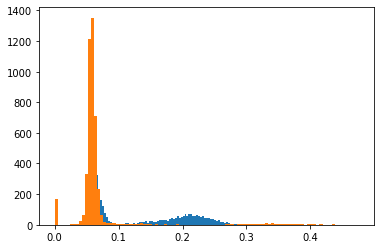

In [12]:
plt.figure()
_ = plt.hist( mngr.get_cc(5,1), 100 )
_ = plt.hist( mngr.get_cc(5,2), 100 )

In [17]:
# Continue processing only with first class
ptcls = mngr.get_ptcls(5)
p1 = susan.data.Particles.MRA.select_ref(ptcls,0)
p1.save('prj_002.ptclsraw')

In [28]:
avgr = susan.modules.Averager()
avgr.list_gpus_ids  = [0]
avgr.ctf_correction = 'wiener'
avgr.rec_halfsets   = False
avgr.reconstruct('prj_002','tomos_b2.tomostxt','prj_002.ptclsraw',128)

    Volume reconstruction. Box size: 128
    - Input files: prj_002.ptclsraw | tomos_b2.tomostxt
    - Output prefix: prj_002
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 30.0]  (roll off: 10.00).
    - Wiener Inversion. Normalized to Mean=0, Std=1.
    - c1 Symmetry. Inversion: Ite=10 Std=0.750000
	Loading data files... Done
    - 3563 Particles (1 classes) in 4 tomograms with max 61 projections.
        Filling fourier space: 100.00%                           
        Reconstructing prj_002_class001.mrc ...  Done.


In [39]:
a = susan.utils.bandpass(susan.read('prj_002_class001.mrc'),lowpass=20) # lowpass in fourier pixels
t = np.quantile(a.flatten(),0.1)
b = (a<th)*(susan.utils.create_sphere(38,128)>0.5)
b = dilat(b,structure=susan.utils.create_sphere(3,8))
c = gauss(np.float32(b),1.5)
susan.io.mrc.write(c,'mask_b2_01.mrc')

refs = susan.data.Reference(n_refs=1)
refs.ref[0] = 'prj_002_class001.mrc'
refs.msk[0] = 'mask_b2_01.mrc'
refs.save('prj_002.refstxt')

In [6]:
mngr = susan.project.Manager('prj_002_b2',128)

mngr.initial_reference = 'prj_002.refstxt'
mngr.initial_particles = 'prj_002.ptclsraw'
mngr.tomogram_file      = 'tomos_b2.tomostxt'
mngr.list_gpus_ids     = [0]
mngr.aligner.ctf_correction  = 'cfsc'
mngr.aligner.allow_drift     = True
mngr.averager.ctf_correction = 'wiener'
mngr.cc_threshold   = 0.9
mngr.iteration_type = 3

In [44]:
mngr.aligner.bandpass.highpass = 0

mngr.aligner.refine.factor = 2
mngr.aligner.set_offset_search(10,1)

lp = 30
for i in range(1,11):
    ang_stp = np.rad2deg(np.arctan2(1,lp))
    mngr.aligner.bandpass.lowpass = lp
    if i == 1:
        mngr.aligner.set_angular_search(0,1,0,1)
        mngr.aligner.refine.levels = 0
    else:
        mngr.aligner.set_angular_search(4*ang_stp,ang_stp,4*ang_stp,ang_stp)
        mngr.aligner.refine.levels = 1
    bp = mngr.execute_iteration(i)
    if i == 1:
        lp = bp
    else:
        lp = min(lp+2,bp)

Project: prj_002_b2 (Iteration 1)
  [3D Alignment] Start:
  Volume 3D alignment. Box size: 128
    - Input files: tomos_b2.tomostxt | prj_002.refstxt
    - Particles In/Out: prj_002.ptclsraw | prj_002_b2/ite_0001/particles.ptclsraw
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 30.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=0.000,1.000 | Inplace=0.000,1.000 | Refinement: 0|2.
    - Angles | 1 [1].
    - Ellipsoid offset (3D): [10.00,10.00,10.00], Step=1.00. Points: 4169
    - 3563 Particles (1 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 23.1 seconds (0:00:23.129555).
  [Aligned partices] Processing:
    Class  1:    3206 particles.
      Half 1:    1619 particles.
      Half 2:    1587 particles.
  [Aligned partices] Done.
  [Reconstruct Maps] Start:
    Volume reconstruction (including half-s

  Volume 3D alignment. Box size: 128
    - Input files: tomos_b2.tomostxt | prj_002_b2/ite_0004/reference.refstxt
    - Particles In/Out: prj_002_b2/ite_0004/particles.ptclsraw | prj_002_b2/ite_0005/particles.ptclsraw
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 50.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=0.080,0.020 | Inplace=0.080,0.020 | Refinement: 1|2.
    - Angles | 100 | 100 [200].
    - Ellipsoid offset (3D): [10.00,10.00,10.00], Step=1.00. Points: 4169
    - 3563 Particles (1 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 1477.5 seconds (0:24:37.520778).
  [Aligned partices] Processing:
    Class  1:    3206 particles.
      Half 1:    1619 particles.
      Half 2:    1587 particles.
  [Aligned partices] Done.
  [Reconstruct Maps] Start:
    Volume reconstruction (including half-set

        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 1481.2 seconds (0:24:41.208040).
  [Aligned partices] Processing:
    Class  1:    3206 particles.
      Half 1:    1619 particles.
      Half 2:    1587 particles.
  [Aligned partices] Done.
  [Reconstruct Maps] Start:
    Volume reconstruction (including half-sets). Box size: 128
    - Input files: prj_002_b2/ite_0009/temp.ptclsraw | tomos_b2.tomostxt
    - Output prefix: prj_002_b2/ite_0009/map
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 63.0]  (roll off: 2.00).
    - Wiener Inversion. Normalized to Mean=0, Std=1.
    - c1 Symmetry. Inversion: Ite=10 Std=0.750000
	Loading data files... Done
    - 3206 Particles (1 classes) in 4 tomograms with max 61 projections.
        Filling fourier space: 100.00%                           
        Reconstructing prj_002_b2/ite_0009/map_class001_half1.mrc ...  Done.
        Reconstructing prj_002_b2/ite_0009/map_class001_ha

In [13]:
ptcls = mngr.get_ptcls(10)
susan.data.Particles.MRA.duplicate(ptcls,0)
ptcls.ref_cix[:] = np.random.binomial(1,0.5,size=ptcls.ref_cix.shape)
ptcls.save('prj_003.ptclsraw')

avgr = susan.modules.Averager()
avgr.list_gpus_ids  = [0]
avgr.ctf_correction = 'wiener'
avgr.rec_halfsets   = False
avgr.reconstruct('prj_003','tomos_b2.tomostxt','prj_003.ptclsraw',128)

refs = susan.data.Reference(n_refs=2)
refs.ref[0] = 'prj_003_class001.mrc'
refs.msk[0] = 'mask_b2_01.mrc'
refs.ref[1] = 'prj_003_class001.mrc'
refs.msk[1] = 'mask_b2_01.mrc'
refs.save('prj_003.refstxt')

In [3]:
mngr = susan.project.Manager('prj_003_b2',128)

mngr.initial_reference = 'prj_003.refstxt'
mngr.initial_particles = 'prj_003.ptclsraw'
mngr.tomogram_file      = 'tomos_b2.tomostxt'
mngr.list_gpus_ids     = [0]
mngr.aligner.ctf_correction  = 'cfsc'
mngr.aligner.allow_drift     = True
mngr.averager.ctf_correction = 'wiener'
mngr.cc_threshold   = 0.4
mngr.iteration_type = 3

In [16]:
mngr.aligner.bandpass.highpass = 0

mngr.aligner.refine.factor = 1
mngr.aligner.set_offset_search(10,1)

for i in range(1,6):
    mngr.aligner.bandpass.lowpass = 50
    mngr.aligner.set_angular_search(4,1,4,1)
    mngr.aligner.refine.levels = 0
    _ = mngr.execute_iteration(i)

Project: prj_003_b2 (Iteration 1)
  [3D Alignment] Start:
  Volume 3D alignment. Box size: 128
    - Input files: tomos_b2.tomostxt | prj_003.refstxt
    - Particles In/Out: prj_003.ptclsraw | prj_003_b2/ite_0001/particles.ptclsraw
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 50.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=4.000,1.000 | Inplace=4.000,1.000 | Refinement: 0|1.
    - Angles | 100 [100].
    - Ellipsoid offset (3D): [10.00,10.00,10.00], Step=1.00. Points: 4169
    - 3563 Particles (2 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 1496.7 seconds (0:24:56.705014).
  [Aligned partices] Processing:
    Class  1:    1049 particles.
      Half 1:     523 particles.
      Half 2:     526 particles.
    Class  2:     377 particles.
      Half 1:     197 particles.
      Half 2:     180 part

  [Aligned partices] Done.
  [Reconstruct Maps] Start:
    Volume reconstruction (including half-sets). Box size: 128
    - Input files: prj_003_b2/ite_0004/temp.ptclsraw | tomos_b2.tomostxt
    - Output prefix: prj_003_b2/ite_0004/map
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 63.0]  (roll off: 2.00).
    - Wiener SSNR: S=1.00 F=0.20. Normalized to Mean=0, Std=1.
    - c1 Symmetry. Inversion: Ite=10 Std=0.750000
	Loading data files... Done
    - 1426 Particles (2 classes) in 4 tomograms with max 61 projections.
        Filling fourier space: 100.00%                           
        Reconstructing prj_003_b2/ite_0004/map_class001_half1.mrc ...  Done.
        Reconstructing prj_003_b2/ite_0004/map_class001_half2.mrc ...  Done.
        Reconstructing prj_003_b2/ite_0004/map_class001.mrc ...  Done.
        Reconstructing prj_003_b2/ite_0004/map_class002_half1.mrc ...  Done.
        Reconstructing prj_003_b2/ite_0004/map_class002_half2.mrc ...  Done.
        Reconstruc

In [51]:
ptcls = mngr.get_ptcls(5)
p1 = susan.data.Particles.MRA.select_ref(ptcls,0)
p1.save('prj_004.ptclsraw')

avgr = susan.modules.Averager()
avgr.list_gpus_ids  = [0]
avgr.ctf_correction = 'wiener'
avgr.rec_halfsets   = False
avgr.reconstruct('prj_004','tomos_b1.tomostxt','prj_004.ptclsraw',256)

a = susan.utils.bandpass(susan.read('prj_004_class001.mrc'),lowpass=40)
t = np.quantile(a.flatten(),0.1)
print(t)
b = (a<t)*(susan.utils.create_sphere(70,256)>0.5)
b = dilat(b,structure=susan.utils.create_sphere(6,14))
c = gauss(np.float32(b),2)
susan.io.mrc.write(c,'mask_b1_01.mrc')

refs = susan.data.Reference(n_refs=1)
refs.ref[0] = 'prj_004_class001.mrc'
refs.msk[0] = 'mask_b1_01.mrc'
refs.save('prj_004.refstxt')

-0.0024324868572875857


In [52]:
mngr = susan.project.Manager('prj_004_b1',256)

mngr.initial_reference = 'prj_004.refstxt'
mngr.initial_particles = 'prj_004.ptclsraw'
mngr.tomogram_file      = 'tomos_b1.tomostxt'
mngr.list_gpus_ids     = [0]
mngr.aligner.ctf_correction  = 'cfsc'
mngr.aligner.allow_drift     = True
mngr.averager.ctf_correction = 'wiener'
mngr.cc_threshold   = 0.9
mngr.iteration_type = 3

In [11]:
mngr.aligner.bandpass.highpass = 0

mngr.aligner.refine.factor = 2
mngr.aligner.set_offset_search(6,1)

lp = 40
for i in range(1,7):
    ang_stp = np.rad2deg(np.arctan2(1,lp))
    mngr.aligner.bandpass.lowpass = lp
    if i == 1:
        mngr.aligner.set_angular_search(0,1,0,1)
        mngr.aligner.refine.levels = 0
    else:
        mngr.aligner.set_angular_search(4*ang_stp,ang_stp,4*ang_stp,ang_stp)
        mngr.aligner.refine.levels = 1
    bp = mngr.execute_iteration(i)
    lp = min(lp+2.5,bp)

Project: prj_004_b1 (Iteration 1)
  [3D Alignment] Start:
  Volume 3D alignment. Box size: 256
    - Input files: tomos_b1.tomostxt | prj_004.refstxt
    - Particles In/Out: prj_004.ptclsraw | prj_004_b1/ite_0001/particles.ptclsraw
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 40.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=0.000,1.000 | Inplace=0.000,1.000 | Refinement: 0|2.
    - Angles | 1 [1].
    - Ellipsoid offset (3D): [6.00,6.00,6.00], Step=1.00. Points: 925
    - 2176 Particles (1 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 40.1 seconds (0:00:40.121247).
  [Aligned partices] Processing:
    Class  1:    1958 particles.
      Half 1:    1013 particles.
      Half 2:     945 particles.
  [Aligned partices] Done.
  [Reconstruct Maps] Start:
    Volume reconstruction (including half-sets)

  Volume 3D alignment. Box size: 256
    - Input files: tomos_b1.tomostxt | prj_004_b1/ite_0004/reference.refstxt
    - Particles In/Out: prj_004_b1/ite_0004/particles.ptclsraw | prj_004_b1/ite_0005/particles.ptclsraw
    - 1 GPU (GPU id: 0), and 1 thread.
    - Bandpass: [0.0 - 50.0]  (roll off: 2.00).
    - On Substack (CFSC). Normalized to Mean=0, Std=1.
    - Angular search: Sym=c1 | Cone=0.080,0.020 | Inplace=0.080,0.020 | Refinement: 1|2.
    - Angles | 100 | 100 [200].
    - Ellipsoid offset (3D): [6.00,6.00,6.00], Step=1.00. Points: 925
    - 2176 Particles (1 classes) in 4 tomograms with max 61 projections.
        Aligning particles: 100.00%                              
  [3D Alignment] Finished. Elapsed time: 3252.4 seconds (0:54:12.404721).
  [Aligned partices] Processing:
    Class  1:    1958 particles.
      Half 1:    1013 particles.
      Half 2:     945 particles.
  [Aligned partices] Done.
  [Reconstruct Maps] Start:
    Volume reconstruction (including half-sets). 

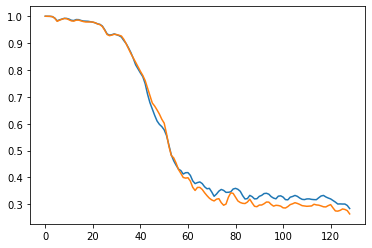

In [53]:
_ = napari.view_image(-susan.utils.bandpass(mngr.get_map(6),52))
plt.plot( mngr.get_fsc(1) )
plt.plot( mngr.get_fsc(6) )

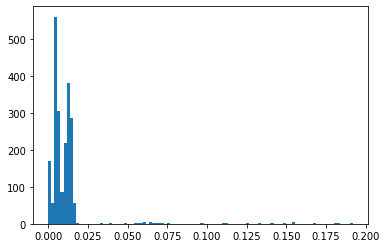

In [55]:
ptcls = mngr.get_ptcls(6)
_ = plt.hist(ptcls.ali_cc[0],100)